<a href="https://colab.research.google.com/github/nojihun/project1/blob/main/%EA%B0%84%EB%8B%A8%ED%95%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import pandas as pd
from tensorflow import keras as k
from keras.utils import np_utils
import cv2
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense


In [2]:
drive.mount('/content/drive') # 구글 드라이브에 연동
directory1 = '/content/drive/MyDrive/samples'
file_list1 = os.listdir(directory1)# 구글 드라이브에서 폴더 읽기


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
X=[]
y=[]

for dirname, _, filenames in os.walk(directory1):
    for filename in filenames:
        path=os.path.join(dirname, filename) 
        
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  

        kernel = np.ones((5,5),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        

        kernel = np.ones((2,2),np.uint8)
        image = cv2.dilate(image, kernel, iterations = 1)
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# 이미지를 글자별로 나누기 위해서 5등분 하는
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# 그 이후에 하나씩 모으기
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)

In [7]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)# 라벨 인코딩
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

In [8]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 16)        0         
 2D)                                                    

In [10]:
from keras.callbacks import EarlyStopping


batch_size = 150
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[es])

Epoch 1/200
58/58 [==============================] - 9s 164ms/step - loss: 1.4639 - accuracy: 0.5796 - val_loss: 1.0416 - val_accuracy: 0.7285
Epoch 2/200
58/58 [==============================] - 6s 103ms/step - loss: 1.1517 - accuracy: 0.6700 - val_loss: 0.9468 - val_accuracy: 0.7416
Epoch 3/200
58/58 [==============================] - 6s 104ms/step - loss: 0.9664 - accuracy: 0.7231 - val_loss: 0.7649 - val_accuracy: 0.7808
Epoch 4/200
58/58 [==============================] - 6s 103ms/step - loss: 0.8703 - accuracy: 0.7459 - val_loss: 0.6476 - val_accuracy: 0.8304
Epoch 5/200
58/58 [==============================] - 6s 103ms/step - loss: 0.7800 - accuracy: 0.7752 - val_loss: 0.5864 - val_accuracy: 0.8425
Epoch 6/200
58/58 [==============================] - 6s 104ms/step - loss: 0.7279 - accuracy: 0.7882 - val_loss: 0.5568 - val_accuracy: 0.8444
Epoch 7/200
58/58 [==============================] - 6s 104ms/step - loss: 0.7059 - accuracy: 0.7895 - val_loss: 0.5286 - val_accuracy: 0.8542

In [12]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

67/67 [==============================] - 1s 16ms/step - loss: 0.1352 - accuracy: 0.9701
Test loss: 0.13522621989250183
Test accuracy: 0.9700934290885925


In [13]:
def pred (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

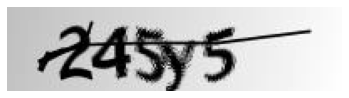

Prediction: 245y5
Actual:     245y5


In [16]:
pred(directory1+ '/'+'245y5.png')

In [17]:
model.save(directory1+ '/'+'captcha_recognizer.h5')

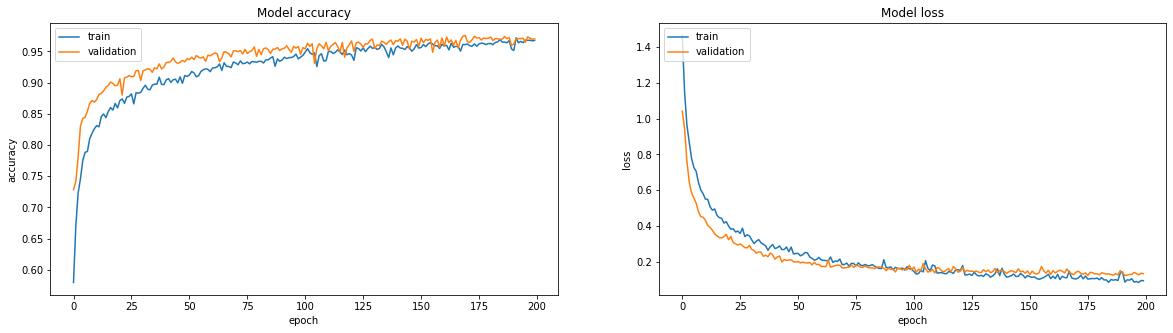

In [20]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()